In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

file = "dataR2.csv"
df = pd.read_csv(file)
X_data = df.drop(columns=["Classification"])
y_data= df["Classification"]



In [83]:
import numpy as np
from scipy.stats import kruskal
from sklearn.metrics import roc_curve, auc
from plotly.subplots import make_subplots
import plotly.express as px
import math


def kruskal_feature_selection(X, y, alpha=0.05):
    """Retorna (selected_features, p_values) usando Kruskal-Wallis."""
    kruskal_selected_features = []
    p_values = {}
    classes = np.unique(y)
    for feature in X.columns:
        groups = [X.loc[y == c, feature] for c in classes]
        stat, p = kruskal(*groups)
        p_values[feature] = p
        if p < alpha:
            kruskal_selected_features.append(feature)
    return kruskal_selected_features, p_values


def compute_roc_auc_per_feature(X, y, pos_label=None, cols=2, auc_threshold=0.6):
    """Calcula ROC/AUC por feature, retorna (selected_feature_names, roc_auc_array, fig)."""
    fnames = np.array(X.columns)
    if pos_label is None:
        classes = np.unique(y)
        pos_label = classes[-1]
    roc_auc = np.zeros(fnames.shape)
    n_features = len(fnames)
    rows = math.ceil(n_features / cols)
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f for f in fnames], horizontal_spacing=0.1, vertical_spacing=0.1)
    for idx, f in enumerate(fnames):
        x_feat = X[f].to_numpy().astype(float)
        y_true = y.to_numpy()
        fpr, tpr, _ = roc_curve(y_true, x_feat, pos_label=pos_label)
        a = auc(fpr, tpr)
        if a < 0.5:
            a = 1 - a
        roc_auc[idx] = a
        row = (idx // cols) + 1
        col = (idx % cols) + 1
        fig.add_scatter(x=fpr, y=tpr, mode='lines+markers', line=dict(color='#636EFA'), marker=dict(color='#636EFA'), showlegend=False, row=row, col=col)
        fig.add_annotation(x=0.5, y=0.5, text=f"AUC: {a:.3f}", showarrow=False, yshift=10, row=row, col=col)
    fig.update_xaxes(title_text="1 - Specificidade (FPR)", range=[-0.01, 1.01])
    fig.update_yaxes(title_text="Sensibilidade (TPR)", range=[-0.01, 1.01])
    fig.update_layout(autosize=False, height=700 * rows, width=1400, showlegend=False)
    selected = fnames[roc_auc > auc_threshold]
    return selected, roc_auc, fig


def plot_correlation_matrix(X, features):
    """Retorna uma figura de matriz de correlação das features (usando plotly)."""
    X_roc = X[features].to_numpy().T
    corrMat = np.corrcoef(X_roc)
    fig = px.imshow(corrMat, text_auto=True, labels=dict(x="Features", y="Features", color="Correlação"), x=features, y=features, width=1000, height=1000, color_continuous_scale=px.colors.sequential.gray)
    fig.update_layout(title="Matriz de Correlação entre TODAS as Features (Treino)")
    return fig


def data(X, y, test_size=0.2, val_size=0.25, random_state=42, stratify=True):
    """Retorna X_train, X_val, X_test, y_train, y_val, y_test"""
    from sklearn.model_selection import train_test_split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y if stratify else None)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=random_state, stratify=y_train_val if stratify else None)
    return X_train, X_val, X_test, y_train, y_val, y_test
X_train_do_a_data, X_val_do_a_data, X_test_do_a_data, y_train_do_a_data, y_val_do_a_data, y_test_do_a_data = data(X_data, y_data, test_size=0.2, val_size=0.25, random_state=42)


In [84]:
# Seleção de features com Kruskal-Wallis
kruskal_selected_features, p_values = kruskal_feature_selection(X_data, y_data)
for feature in kruskal_selected_features:
    print(f"Feature: {feature}, p-value: {p_values[feature]:.6f}")
print("kruskal_selected_features:", kruskal_selected_features)

# ROC-AUC por feature (plota grelha)
roc_auc_selected_features, roc_auc_values, figR = compute_roc_auc_per_feature(X_data, y_data, cols=2, auc_threshold=0.60)
print("roc_auc_selected_features:", roc_auc_selected_features)
figR.show()

# Matriz de Correlação entre as features selecionadas pelo Kruskal
fig_corr = plot_correlation_matrix(X_data, kruskal_selected_features)
fig_corr.show()

# Filtrar X para manter apenas as features selecionadas
X = X_data[kruskal_selected_features]

# Divisão treino/val/test
X_train, X_val, X_test, y_train, y_val, y_test = data(X, y_data, test_size=0.2, val_size=0.25, random_state=42)

print(f"Tamanho treino:      {len(X_train)}")
print(f"Tamanho validação:   {len(X_val)}")
print(f"Tamanho teste:       {len(X_test)}")

# Salvar X_train
X_train.to_csv("X_train.csv", index=False)


Feature: Glucose, p-value: 0.000001
Feature: Insulin, p-value: 0.026379
Feature: HOMA, p-value: 0.002872
Feature: Resistin, p-value: 0.001843
kruskal_selected_features: ['Glucose', 'Insulin', 'HOMA', 'Resistin']
roc_auc_selected_features: ['Glucose' 'Insulin' 'HOMA' 'Resistin']


Tamanho treino:      69
Tamanho validação:   23
Tamanho teste:       24


In [85]:
#Removemos a insulina pq tem alta correlaçao com a homa mas tem um p-value mais alto 
#kruskal_selected_features.remove('Insulin')


In [86]:

# -------------------- Dimensionality Reduction (utilities) -----

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.express as px

def scaler(X_train, X_val, X_test):
    """Fit StandardScaler on X_train and transform X_val/X_test.
    Accepts pandas DataFrame or numpy arrays and returns numpy arrays.
    """
    X_train_array = X_train.to_numpy() if hasattr(X_train, "to_numpy") else np.asarray(X_train)
    X_val_array = X_val.to_numpy() if hasattr(X_val, "to_numpy") else np.asarray(X_val)
    X_test_array = X_test.to_numpy() if hasattr(X_test, "to_numpy") else np.asarray(X_test)
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train_array)
    X_val_std = scaler.transform(X_val_array)
    X_test_std = scaler.transform(X_test_array)
    return X_train_std, X_val_std, X_test_std, scaler
X_train_do_a_data_std, X_val_do_a_data_std, X_test_do_a_data_std, scaler_do_a_data = scaler(X_train_do_a_data, X_val_do_a_data, X_test_do_a_data)

def pca(X_train_std, n_components=None, show_scree=True):
    """Fit PCA on training data, print report and optionally show scree plot.
    Returns fitted `pca` and component matrix `W`.
    """
    pca = PCA(n_components=n_components)
    pca.fit(X_train_std)
    print("PCA eigenvalues/Explained variance")
    print(pca.explained_variance_)
    print("Sum of eigenvalues=" + str(np.sum(pca.explained_variance_)))
    print("PCA eigenvectors/Principal components")
    W = pca.components_.T
    print(W)
    if show_scree:
        fig = px.scatter(x=np.arange(1, len(pca.explained_variance_) + 1),
                         y=pca.explained_variance_,
                         labels=dict(x="PC", y="Explained Variance"))
        fig.add_hline(y=1, line_width=3, line_dash="dash", line_color="red")
        fig.update_traces(marker_size=10)
        fig.show()
    return pca, W


X_train_std, X_val_std, X_test_std, scaler = scaler(X_train, X_val, X_test)

X_train
pca_full, W = pca(X_train_std, n_components=None, show_scree=True)
pca_do_o_a_data,w = pca(X_train_do_a_data_std, n_components=None, show_scree=True)

print("Variance (%) retained accourding to Kaiser: " +
      str(pca_full.explained_variance_[0]**2 / (np.sum(pca_full.explained_variance_**2)) * 100))
print("Variance (%) retained accourding to Scree: " +
      str(np.sum(pca_full.explained_variance_[0:3]**2) / (np.sum(pca_full.explained_variance_**2)) * 100))

# PCA with n_components=2 (dimensionality reduction used later)
pca = PCA(n_components=2)
X_train_do_reduction_pca = pca.fit_transform(X_train_std)
X_val_do_reduction_pca = pca.transform(X_val_std)
X_test_do_reduction_pca = pca.transform(X_test_std)

pca = PCA(n_components=4)
X_train_do_a_reduction_data_pca = pca.fit_transform(X_train_do_a_data_std)
X_val_do_a_reduction_data_pca= pca.transform(X_val_do_a_data_std)
X_test_do_a_reduction_data_pca = pca.transform(X_test_do_a_data_std)




PCA eigenvalues/Explained variance
[2.66317327 0.94641169 0.41561352 0.03362505]
Sum of eigenvalues=4.0588235294117645
PCA eigenvectors/Principal components
[[ 0.52276621  0.12785984  0.80500912 -0.24965512]
 [ 0.55347396 -0.29792031 -0.4975053  -0.59782818]
 [ 0.59265706 -0.24047764 -0.11075854  0.76069748]
 [ 0.26294423  0.91491303 -0.30361381  0.04016387]]


PCA eigenvalues/Explained variance
[3.39937515 1.51370481 1.35353887 1.09857836 0.63367146 0.489201
 0.33317247 0.28139814 0.02971268]
Sum of eigenvalues=9.132352941176473
PCA eigenvectors/Principal components
[[ 0.09124365  0.06631334  0.20826455  0.86173474  0.35918137  0.01295465
   0.24776193  0.1025244  -0.01549009]
 [ 0.26976908 -0.41526268  0.49064949 -0.19698031  0.05405953 -0.1228377
  -0.06355129  0.67233231  0.03409325]
 [ 0.41817988  0.229679   -0.20288689  0.07584906  0.05539931  0.59218733
  -0.52185083  0.21065684 -0.23451536]
 [ 0.44270869  0.34601931  0.03187266 -0.07051925 -0.29348134 -0.32612375
   0.35958441  0.02042474 -0.59672833]
 [ 0.47055691  0.3696771  -0.055869    0.0103968  -0.18414351 -0.15019912
   0.04584935  0.03645875  0.76077959]
 [ 0.28745844  0.03089067  0.5866371  -0.25934015  0.33409225  0.23178401
   0.0392825  -0.58145779  0.00593974]
 [-0.22461883  0.51149621 -0.09908361 -0.35312642  0.62776815 -0.02193226
   0.20820543  0.33975521  0.00672373]


Variance (%) retained accourding to Kaiser: 86.89593862394149
Variance (%) retained accourding to Scree: 99.98614755080267


In [87]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import plotly.express as px
import pandas as pd
def lda_transform(X_train_std, y_train, X_val_std, X_test_std):
    """Fit LDA on training data and transform train/val/test sets."""
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train_std, y_train)
    X_val_lda = lda.transform(X_val_std)
    X_test_lda = lda.transform(X_test_std)
    return lda,X_train_lda, X_val_lda, X_test_lda
lda,X_train_lda_transformed, X_val_lda_transformed, X_test_lda_transformed = lda_transform(X_train_std, y_train, X_val_std, X_test_std)


lda,X_train_lda_a_data_transformed, X_val_lda_a_data_transformed,X_test_lda_a_data_tranformed = lda_transform(X_train_do_a_data_std,y_train_do_a_data,X_val_do_a_data_std,X_test_do_a_data_std)
#Plot transformed data (treino)
fig = px.scatter(x=X_train_lda_transformed[:,0], y=np.zeros_like(X_train_lda_transformed[:,0]), color=y_train.astype(str), labels=dict(x="LDA1", y="", color="Class"))
fig.update_traces(marker_size=10)
lda,X_train_lda_s,X_val_lda_s,X_test_lda_s = lda_transform(X_train_std, y_train, X_val_std, X_test_std)

In [88]:
from sklearn.metrics import confusion_matrix
def calculate_metrics(y_true, y_pred):
    """Calculate classification metrics (Sensitivity, Specificity, Precision, F1 Score, Accuracy).
    
    Returns dict with metrics as percentages.
    """
    y_true = y_true if isinstance(y_true, np.ndarray) else y_true.to_numpy()
    y_pred = y_pred if isinstance(y_pred, np.ndarray) else np.asarray(y_pred)
    
    ix_1 = np.where(y_true == 1)[0]
    ix_2 = np.where(y_true == 2)[0]
    
    TPTr = np.shape(np.where((y_true[ix_1] == y_pred[ix_1]))[0])[0]
    TNTr = np.shape(np.where((y_true[ix_2] == y_pred[ix_2]))[0])[0]
    FPTr = np.shape(np.where((y_true[ix_2] != y_pred[ix_2]))[0])[0]
    FNTr = np.shape(np.where((y_true[ix_1] != y_pred[ix_1]))[0])[0]
    
    SSTr = TPTr/(TPTr+FNTr) if (TPTr+FNTr) else 0.0
    SPTr = TNTr/(TNTr+FPTr) if (TNTr+FPTr) else 0.0
    PRTr = TPTr/(TPTr+FPTr) if (TPTr+FPTr) else 0.0
    F1ScoreTr = 2*(PRTr*SSTr)/(PRTr+SSTr) if (PRTr+SSTr) else 0.0
    ACTr = (TNTr+TPTr)/(TPTr+TNTr+FPTr+FNTr)
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'Sensitivity': SSTr*100,
        'Specificity': SPTr*100,
        'Precision': PRTr*100,
        'F1Score': F1ScoreTr*100,
        'Accuracy': ACTr*100,
        'TP': TPTr,
        'TN': TNTr,
        'FP': FPTr,
        'FN': FNTr,
        'Confusion Matrix': cm
    }
def view_metrics(title,metrics):
    print(f"\n--- Métricas de Performance ({title}) ---")
    
    for key, value in metrics.items():
        if key not in ["TP", "TN", "FP", "FN","Confusion Matrix"]:   
            print(f"{key}(%) = {value :.2f}")
    
    print("Confusion Matrix:\n", metrics['Confusion Matrix'])
def mdc_euclidean(X, y):
    """MDC (Minimum Distance Classifier) with Euclidean distance.
    
    Returns predictions and metrics dictionary.
    """
    ix_1 = np.where(y == 1)[0]
    ix_2 = np.where(y == 2)[0]
    
    mu1 = np.array([np.mean(X[ix_1], axis=0)]).T
    mu2 = np.array([np.mean(X[ix_2], axis=0)]).T
    
    yrtp = np.ones(len(y))
    dx = ((mu1-mu2).T @ (X.T - 0.5*(mu1+mu2))).flatten()
    yrtp[dx < 0] = 2
    
    metrics = calculate_metrics(y, yrtp)
    return yrtp, metrics

yrtp,metrics= mdc_euclidean(X_test_std, y_test)
view_metrics("MDC Euclidean - Kruskal",metrics)


--- Métricas de Performance (MDC Euclidean - Kruskal) ---
Sensitivity(%) = 100.00
Specificity(%) = 30.77
Precision(%) = 55.00
F1Score(%) = 70.97
Accuracy(%) = 62.50
Confusion Matrix:
 [[11  0]
 [ 9  4]]


In [89]:
# MDC Euclidean a seguir o LDA
X = X_test_lda_transformed
y = y_test.to_numpy()

yrtp, metrics = mdc_euclidean(X, y)

view_metrics("Teste - MDC Euclidean a seguir ao LDA", metrics)


--- Métricas de Performance (Teste - MDC Euclidean a seguir ao LDA) ---
Sensitivity(%) = 72.73
Specificity(%) = 46.15
Precision(%) = 53.33
F1Score(%) = 61.54
Accuracy(%) = 58.33
Confusion Matrix:
 [[8 3]
 [7 6]]


In [90]:
# MDC Euclidean a seguir o PCA
X = X_test_do_reduction_pca
y = y_test.to_numpy()

yrtp, metrics = mdc_euclidean(X, y)

view_metrics("Teste - MDC Euclidean a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - MDC Euclidean a seguir ao PCA) ---
Sensitivity(%) = 100.00
Specificity(%) = 30.77
Precision(%) = 55.00
F1Score(%) = 70.97
Accuracy(%) = 62.50
Confusion Matrix:
 [[11  0]
 [ 9  4]]


In [91]:
# MDC Euclidean a seguir o LDA com dados do Data
X = X_test_lda_a_data_tranformed
y = y_test.to_numpy()

yrtp, metrics = mdc_euclidean(X, y)

view_metrics("Teste - MDC Euclidean a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - MDC Euclidean a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 53.85
Precision(%) = 60.00
F1Score(%) = 69.23
Accuracy(%) = 66.67
Confusion Matrix:
 [[9 2]
 [6 7]]


In [92]:
X = X_test_do_a_reduction_data_pca
y = y_test.to_numpy()

yrtp, metrics = mdc_euclidean(X, y)

view_metrics("Teste - MDC Euclidean a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - MDC Euclidean a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 100.00
Specificity(%) = 38.46
Precision(%) = 57.89
F1Score(%) = 73.33
Accuracy(%) = 66.67
Confusion Matrix:
 [[11  0]
 [ 8  5]]


In [93]:
X = X_test_do_a_data_std
y= y_test.to_numpy()

yrtp,metrics = mdc_euclidean(X,y)
view_metrics("Teste - MDC Euclidean a seguir ao Data",metrics)



--- Métricas de Performance (Teste - MDC Euclidean a seguir ao Data) ---
Sensitivity(%) = 100.00
Specificity(%) = 30.77
Precision(%) = 55.00
F1Score(%) = 70.97
Accuracy(%) = 62.50
Confusion Matrix:
 [[11  0]
 [ 9  4]]


In [94]:
def mdc_mahalanobis(X, y):
    """MDC with Mahalanobis distance using pooled covariance.
    
    Returns predictions and metrics dictionary.
    """
    ix_1 = np.where(y == 1)[0]
    ix_2 = np.where(y == 2)[0]
    
    mu1 = np.array([np.mean(X[ix_1], axis=0)]).T
    mu2 = np.array([np.mean(X[ix_2], axis=0)]).T
    
    C1 = np.cov(X[ix_1], rowvar=False, bias=False)
    C2 = np.cov(X[ix_2], rowvar=False, bias=False)
    C1 = np.atleast_2d(C1)
    C2 = np.atleast_2d(C2)
    C = (C1 + C2) / 2
    
    Ci = np.linalg.inv(C)
    
    yrtp = np.ones(len(y), dtype=int)
    dx = ((mu1 - mu2).T @ Ci @ (X.T - 0.5*(mu1 + mu2))).flatten()
    yrtp[dx < 0] = 2
    
    metrics = calculate_metrics(y, yrtp)
    return yrtp, metrics


yrtp, metrics = mdc_mahalanobis(X_test_std, y_test)
view_metrics("MDC Mahalanobis - Kruskal", metrics)


--- Métricas de Performance (MDC Mahalanobis - Kruskal) ---
Sensitivity(%) = 72.73
Specificity(%) = 46.15
Precision(%) = 53.33
F1Score(%) = 61.54
Accuracy(%) = 58.33
Confusion Matrix:
 [[8 3]
 [7 6]]


In [95]:
# MDC Mahalanobis a seguir o LDA
X = X_test_lda_transformed
y = y_test.to_numpy()

yrtp, metrics = mdc_mahalanobis(X, y)

view_metrics("Teste - MDC Mahalanobis a seguir ao LDA ", metrics)


--- Métricas de Performance (Teste - MDC Mahalanobis a seguir ao LDA ) ---
Sensitivity(%) = 72.73
Specificity(%) = 46.15
Precision(%) = 53.33
F1Score(%) = 61.54
Accuracy(%) = 58.33
Confusion Matrix:
 [[8 3]
 [7 6]]


In [96]:
X = X_test_do_reduction_pca
y = y_test.to_numpy()

yrtp, metrics = mdc_mahalanobis(X, y)

view_metrics("Teste - MDC Mahalanobis a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - MDC Mahalanobis a seguir ao PCA) ---
Sensitivity(%) = 72.73
Specificity(%) = 38.46
Precision(%) = 50.00
F1Score(%) = 59.26
Accuracy(%) = 54.17
Confusion Matrix:
 [[8 3]
 [8 5]]


In [97]:
X = X_test_lda_a_data_tranformed
y = y_test.to_numpy()

yrtp, metrics = mdc_mahalanobis(X, y)

view_metrics("Teste - MDC Mahalanobis a seguir ao LDA com dados do Data ", metrics)


--- Métricas de Performance (Teste - MDC Mahalanobis a seguir ao LDA com dados do Data ) ---
Sensitivity(%) = 81.82
Specificity(%) = 53.85
Precision(%) = 60.00
F1Score(%) = 69.23
Accuracy(%) = 66.67
Confusion Matrix:
 [[9 2]
 [6 7]]


In [98]:
X = X_test_do_a_reduction_data_pca
y = y_test.to_numpy()

yrtp, metrics = mdc_mahalanobis(X, y)

view_metrics("Teste - MDC Mahalanobis a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - MDC Mahalanobis a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 69.23
Precision(%) = 69.23
F1Score(%) = 75.00
Accuracy(%) = 75.00
Confusion Matrix:
 [[9 2]
 [4 9]]


In [99]:
X = X_test_do_a_data_std
y = y_test.to_numpy()

yrtp, metrics = mdc_mahalanobis(X, y)

view_metrics("Teste - MDC Mahalanobis a seguir ao Data", metrics)


--- Métricas de Performance (Teste - MDC Mahalanobis a seguir ao Data) ---
Sensitivity(%) = 72.73
Specificity(%) = 84.62
Precision(%) = 80.00
F1Score(%) = 76.19
Accuracy(%) = 79.17
Confusion Matrix:
 [[ 8  3]
 [ 2 11]]


In [100]:
def fisher_linear_discriminant(X, y):
    """Fisher Linear Discriminant classifier.
    
    Returns predictions and metrics dictionary.
    """
    ix_1 = np.where(y == 1)[0]
    ix_2 = np.where(y == 2)[0]
    
    mu1 = np.array([np.mean(X[ix_1], axis=0)]).T
    mu2 = np.array([np.mean(X[ix_2], axis=0)]).T
    
    S1 = (X[ix_1,:].T - mu1) @ (X[ix_1,:].T - mu1).T
    S2 = (X[ix_2,:].T - mu2) @ (X[ix_2,:].T - mu2).T
    
    Sw = S1 + S2
    SwInv = np.linalg.inv(Sw)
    
    w = SwInv @ (mu1 - mu2)
    b = -0.5 * (w.T @ mu1 + w.T @ mu2)
    
    yrtp = np.ones(np.shape(y))
    dx = (w.T @ X.T + b).flatten()
    yrtp[dx < 0] = 2
    
    metrics = calculate_metrics(y, yrtp)
    return yrtp, metrics

X = X_test_std
y = y_test.to_numpy()
yrtp, metrics = fisher_linear_discriminant(X, y)
view_metrics("Teste - Fisher Linear Discriminant a seguir ao Kruskal", metrics)


--- Métricas de Performance (Teste - Fisher Linear Discriminant a seguir ao Kruskal) ---
Sensitivity(%) = 72.73
Specificity(%) = 38.46
Precision(%) = 50.00
F1Score(%) = 59.26
Accuracy(%) = 54.17
Confusion Matrix:
 [[8 3]
 [8 5]]


In [101]:
# Fisher LDA
X = X_test_lda_transformed
y = y_test.to_numpy()

yrtp, metrics = fisher_linear_discriminant(X, y)

view_metrics("Teste - Fisher Linear Discriminant a seguir ao LDA", metrics)


--- Métricas de Performance (Teste - Fisher Linear Discriminant a seguir ao LDA) ---
Sensitivity(%) = 72.73
Specificity(%) = 46.15
Precision(%) = 53.33
F1Score(%) = 61.54
Accuracy(%) = 58.33
Confusion Matrix:
 [[8 3]
 [7 6]]


In [102]:
X = X_test_do_reduction_pca
y = y_test.to_numpy()
yrtp, metrics = fisher_linear_discriminant(X, y)
view_metrics("Teste - Fisher Linear Discriminant a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - Fisher Linear Discriminant a seguir ao PCA) ---
Sensitivity(%) = 72.73
Specificity(%) = 38.46
Precision(%) = 50.00
F1Score(%) = 59.26
Accuracy(%) = 54.17
Confusion Matrix:
 [[8 3]
 [8 5]]


In [103]:
X = X_test_lda_a_data_tranformed
y = y_test.to_numpy()
yrtp, metrics = fisher_linear_discriminant(X, y)
view_metrics("Teste - Fisher Linear Discriminant a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - Fisher Linear Discriminant a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 53.85
Precision(%) = 60.00
F1Score(%) = 69.23
Accuracy(%) = 66.67
Confusion Matrix:
 [[9 2]
 [6 7]]


In [104]:
X = X_test_do_a_reduction_data_pca
y = y_test.to_numpy()
yrtp, metrics = fisher_linear_discriminant(X, y)
view_metrics("Teste - Fisher Linear Discriminant a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - Fisher Linear Discriminant a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 72.73
Specificity(%) = 69.23
Precision(%) = 66.67
F1Score(%) = 69.57
Accuracy(%) = 70.83
Confusion Matrix:
 [[8 3]
 [4 9]]


In [105]:
X = X_test_do_a_data_std
y = y_test.to_numpy()
yrtp, metrics = fisher_linear_discriminant(X, y)
view_metrics("Teste - Fisher Linear Discriminant a seguir ao Data", metrics)


--- Métricas de Performance (Teste - Fisher Linear Discriminant a seguir ao Data) ---
Sensitivity(%) = 72.73
Specificity(%) = 84.62
Precision(%) = 80.00
F1Score(%) = 76.19
Accuracy(%) = 79.17
Confusion Matrix:
 [[ 8  3]
 [ 2 11]]


In [106]:
from sklearn import mixture


def fitBayes(Xtr, ytr):
    """Fit Bayes classifier using Gaussian Mixture Models."""
    ix1 = np.where(ytr == 1)[0]
    ix2 = np.where(ytr == 2)[0]
    
    Pw1 = ix1.shape[0] / (ix1.shape[0] + ix2.shape[0])
    Pw2 = ix2.shape[0] / (ix1.shape[0] + ix2.shape[0])
    
    clf1 = mixture.GaussianMixture(n_components=1)
    clf2 = mixture.GaussianMixture(n_components=1)
    mod1 = clf1.fit(Xtr[ix1,:])
    mod2 = clf2.fit(Xtr[ix2,:])
    
    return {'mean1': mod1.means_.squeeze(), 'mean2': mod2.means_.squeeze(),
            'cov1': mod1.covariances_[0], 'cov2': mod2.covariances_[0],
            'Pw1': Pw1, 'Pw2': Pw2}

def pdfGauss(X, mean, cov):
    """Evaluate multivariate Gaussian PDF."""
    covInv = np.linalg.inv(cov)
    dim = cov.shape[0]
    val = np.array([])
    for i in range(X.shape[0]):
        dist = ((np.array([X[i,:] - mean])) @ covInv @ (np.array([X[i,:] - mean])).T).squeeze()
        multivariate_pdf = np.exp(-0.5*dist) / ((2*np.pi)**(dim/2) * np.linalg.det(cov)**0.5)
        val = np.append(val, multivariate_pdf)
    return np.array([val]).T

def useBayes(Xte, model):
    """Classify using Bayes model."""
    Pw1X = pdfGauss(Xte, model['mean1'], model['cov1']) * model['Pw1']
    Pw2X = pdfGauss(Xte, model['mean2'], model['cov2']) * model['Pw2']
    return ((-np.sign(Pw1X - Pw2X)) * 0.5 + 1.5).squeeze()


model = fitBayes(X_train_std, y_train)
yrtp = useBayes(X_test_std, model)

y = y_test.to_numpy()
metrics = calculate_metrics(y, yrtp)
view_metrics("Teste - Bayes a seguir ao Kruskal", metrics)



--- Métricas de Performance (Teste - Bayes a seguir ao Kruskal) ---
Sensitivity(%) = 81.82
Specificity(%) = 46.15
Precision(%) = 56.25
F1Score(%) = 66.67
Accuracy(%) = 62.50
Confusion Matrix:
 [[9 2]
 [7 6]]


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [107]:
model = fitBayes(X_train_lda_transformed, y_train)
yrtp = useBayes(X_test_lda_transformed, model)

y = y_test.to_numpy()
metrics = calculate_metrics(y, yrtp)
view_metrics("Teste - Bayes a seguir ao LDA", metrics)


--- Métricas de Performance (Teste - Bayes a seguir ao LDA) ---
Sensitivity(%) = 81.82
Specificity(%) = 46.15
Precision(%) = 56.25
F1Score(%) = 66.67
Accuracy(%) = 62.50
Confusion Matrix:
 [[9 2]
 [7 6]]


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [108]:
model = fitBayes(X_train_do_reduction_pca, y_train)
yrtp = useBayes(X_test_do_reduction_pca, model)

y = y_test.to_numpy()
metrics = calculate_metrics(y, yrtp)
view_metrics("Teste - Bayes a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - Bayes a seguir ao PCA) ---
Sensitivity(%) = 72.73
Specificity(%) = 38.46
Precision(%) = 50.00
F1Score(%) = 59.26
Accuracy(%) = 54.17
Confusion Matrix:
 [[8 3]
 [8 5]]


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [109]:
model = fitBayes(X_train_lda_a_data_transformed, y_train)
yrtp = useBayes(X_test_lda_a_data_tranformed, model)

y = y_test.to_numpy()
metrics = calculate_metrics(y, yrtp)
view_metrics("Teste - Bayes a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - Bayes a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 61.54
Precision(%) = 64.29
F1Score(%) = 72.00
Accuracy(%) = 70.83
Confusion Matrix:
 [[9 2]
 [5 8]]


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [110]:
model = fitBayes(X_train_do_a_reduction_data_pca, y_train)
yrtp = useBayes(X_test_do_a_reduction_data_pca, model)

y = y_test.to_numpy()
metrics = calculate_metrics(y, yrtp)
view_metrics("Teste - Bayes a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - Bayes a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 90.91
Specificity(%) = 46.15
Precision(%) = 58.82
F1Score(%) = 71.43
Accuracy(%) = 66.67
Confusion Matrix:
 [[10  1]
 [ 7  6]]


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [111]:
model = fitBayes(X_train_do_a_data_std, y_train)
yrtp = useBayes(X_test_do_a_data_std, model)

y = y_test.to_numpy()
metrics = calculate_metrics(y, yrtp)
view_metrics("Teste - Bayes a seguir ao Data", metrics)


--- Métricas de Performance (Teste - Bayes a seguir ao Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 53.85
Precision(%) = 60.00
F1Score(%) = 69.23
Accuracy(%) = 66.67
Confusion Matrix:
 [[9 2]
 [6 7]]


c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\rodmb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.




--- Métricas de Performance (Teste - Decision Tree a seguir ao Kruskal) ---
Sensitivity(%) = 63.64
Specificity(%) = 53.85
Precision(%) = 53.85
F1Score(%) = 58.33
Accuracy(%) = 58.33
Confusion Matrix:
 [[7 4]
 [6 7]]


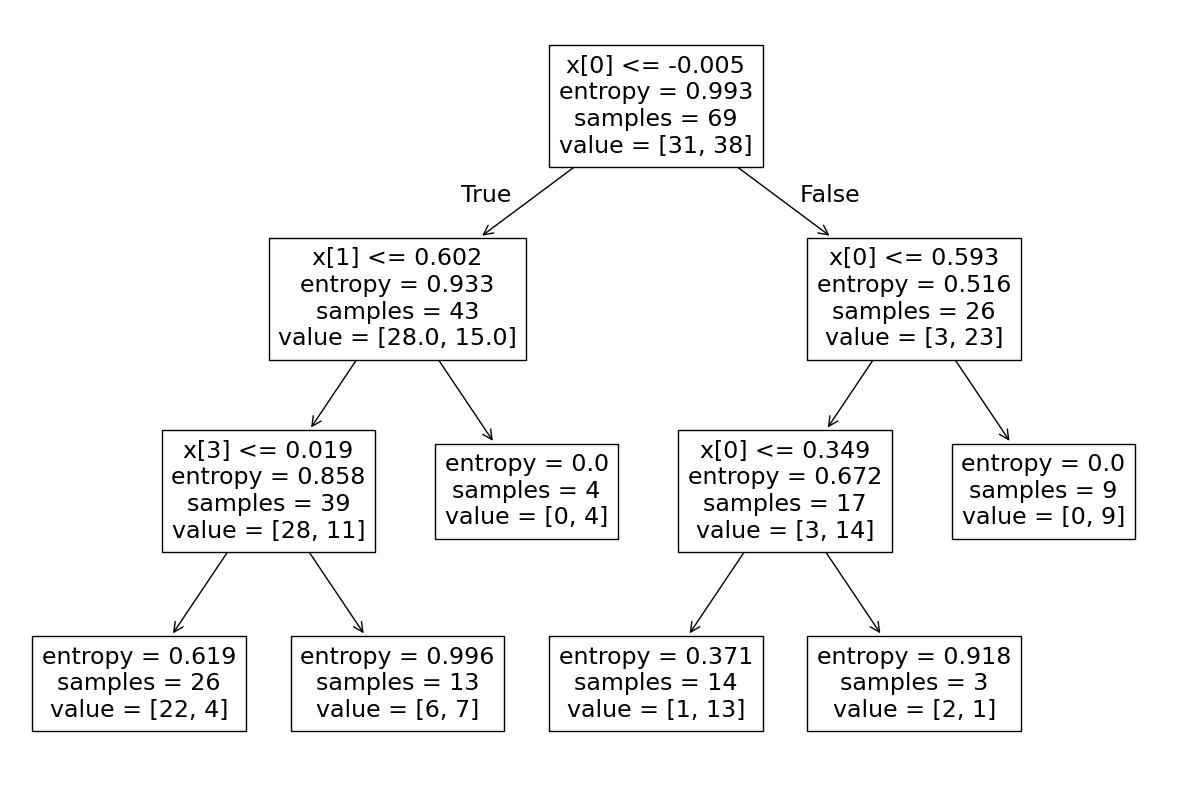

In [112]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

def train_decision_tree(Xtr, ytr, criterion='entropy', max_depth=3):
    """Train Decision Tree classifier."""
    model = DecisionTreeClassifier(criterion=criterion, splitter='best', max_depth=max_depth)
    model.fit(Xtr, ytr)
    return model

def predict(model, Xte, yte):
    """Plot decision tree and make predictions."""
    plt.figure(figsize=(15, 10))
    plot_tree(model)
    plt.savefig("decision_tree.png")
    ydriction = model.predict(Xte)
    y = yte.to_numpy() if hasattr(yte, 'to_numpy') else np.asarray(yte)
    metrics = calculate_metrics(y, ydriction)
    return ydriction, metrics


model = train_decision_tree(X_train_std, y_train, criterion='entropy', max_depth=3)
ydriction, metrics  = predict(model, X_test_std, y_test)
    
view_metrics("Teste - Decision Tree a seguir ao Kruskal", metrics)


--- Métricas de Performance (Teste - Decision Tree a seguir ao LDA) ---
Sensitivity(%) = 45.45
Specificity(%) = 46.15
Precision(%) = 41.67
F1Score(%) = 43.48
Accuracy(%) = 45.83
Confusion Matrix:
 [[5 6]
 [7 6]]


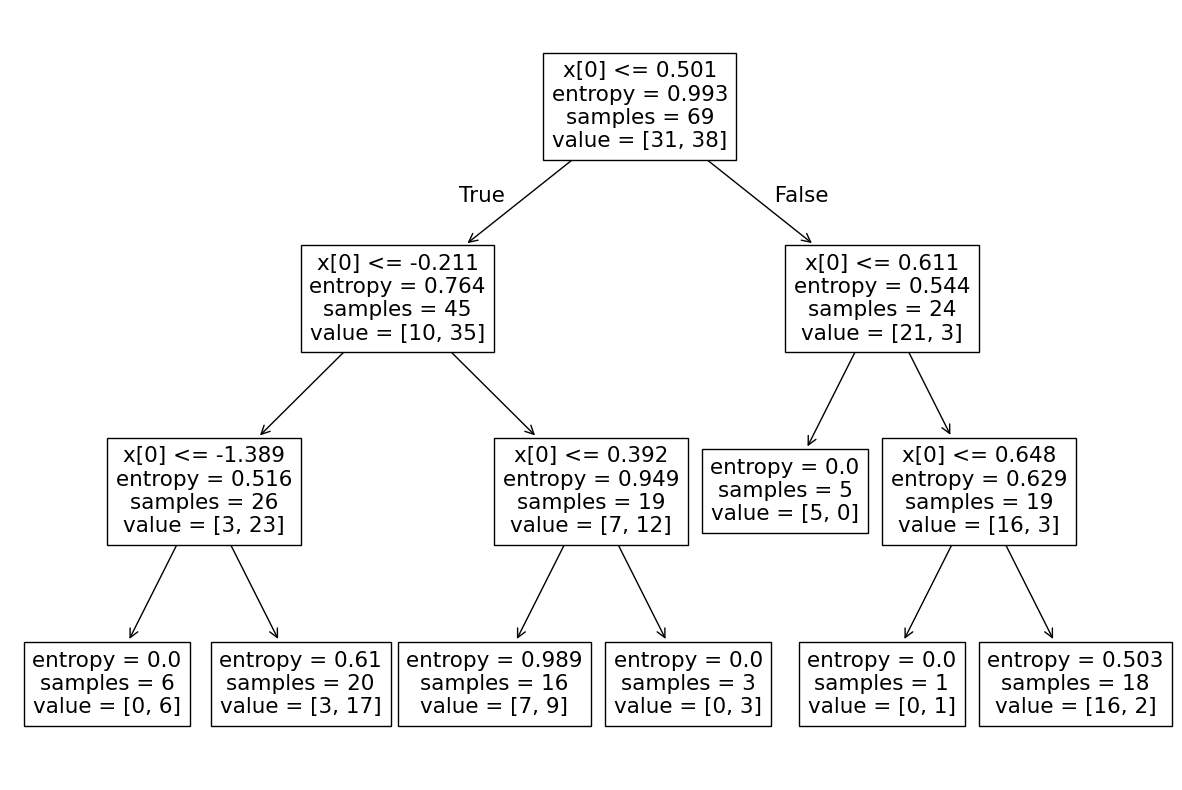

In [113]:
# Decision Tree a seguir o  LDA
model = train_decision_tree(X_train_lda_transformed, y_train, criterion='entropy', max_depth=3)

ydriction, metrics = predict(model, X_test_lda_transformed, y_test)
view_metrics("Teste - Decision Tree a seguir ao LDA", metrics)  



--- Métricas de Performance (Teste - Decision Tree a seguir ao PCA) ---
Sensitivity(%) = 54.55
Specificity(%) = 46.15
Precision(%) = 46.15
F1Score(%) = 50.00
Accuracy(%) = 50.00
Confusion Matrix:
 [[6 5]
 [7 6]]


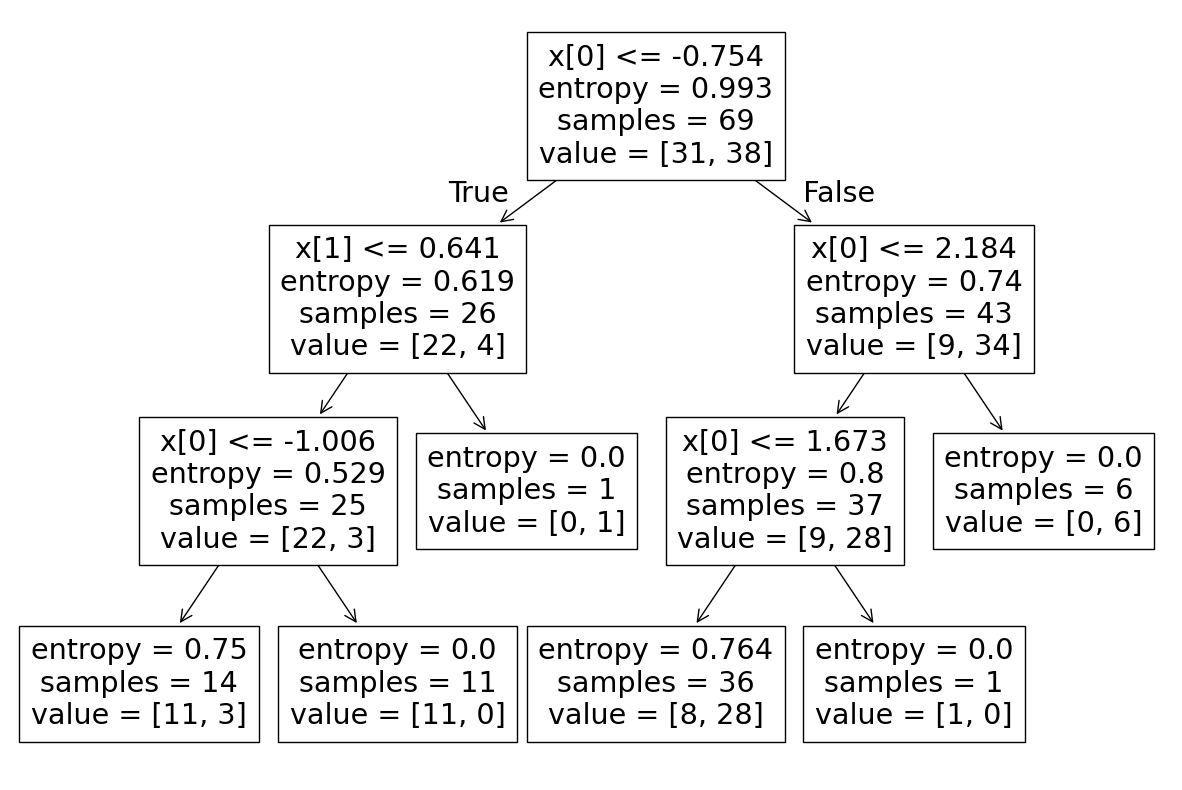

In [114]:
model = train_decision_tree(X_train_do_reduction_pca, y_train, criterion='entropy', max_depth=3)
ydriction, metrics  = predict(model, X_test_do_reduction_pca, y_test)

view_metrics("Teste - Decision Tree a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - Decision Tree a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 63.64
Specificity(%) = 46.15
Precision(%) = 50.00
F1Score(%) = 56.00
Accuracy(%) = 54.17
Confusion Matrix:
 [[7 4]
 [7 6]]


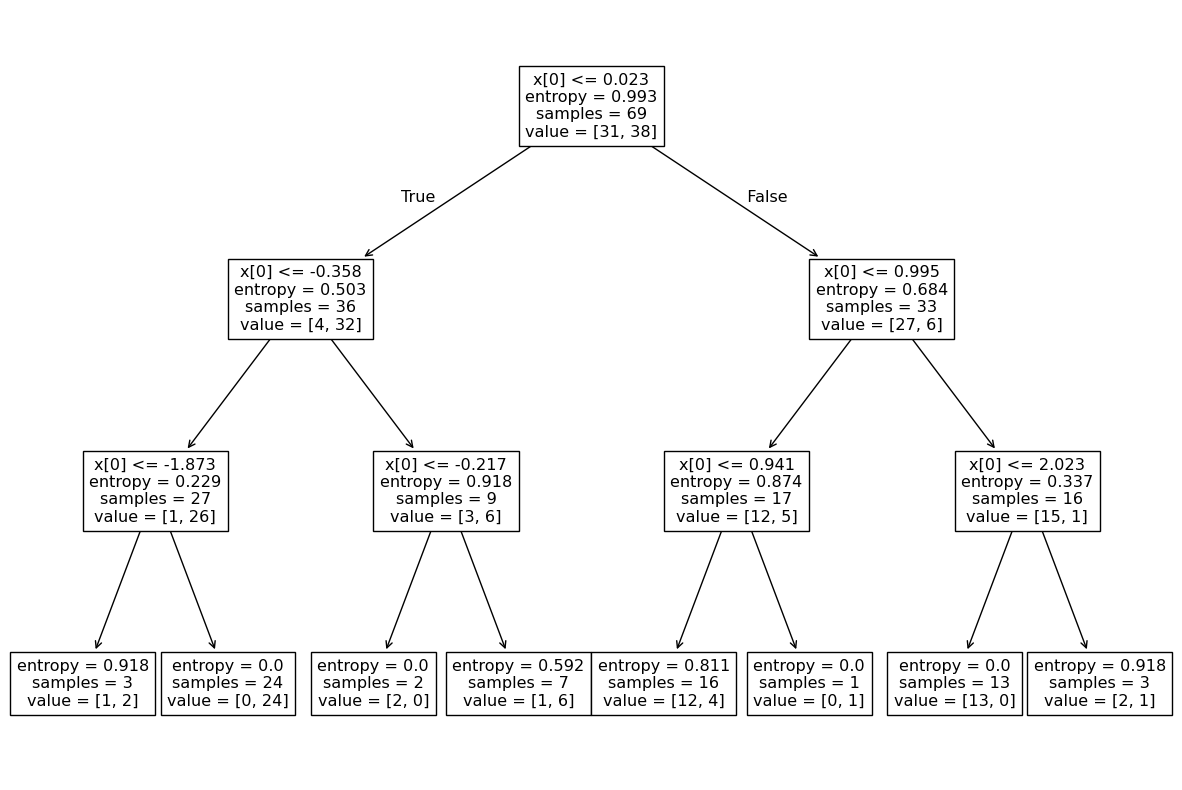

In [115]:
model = train_decision_tree(X_train_lda_a_data_transformed, y_train, criterion='entropy', max_depth=3)
ydriction, metrics  = predict(model, X_test_lda_a_data_tranformed, y_test)

view_metrics("Teste - Decision Tree a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - Decision Tree a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 63.64
Specificity(%) = 84.62
Precision(%) = 77.78
F1Score(%) = 70.00
Accuracy(%) = 75.00
Confusion Matrix:
 [[ 7  4]
 [ 2 11]]


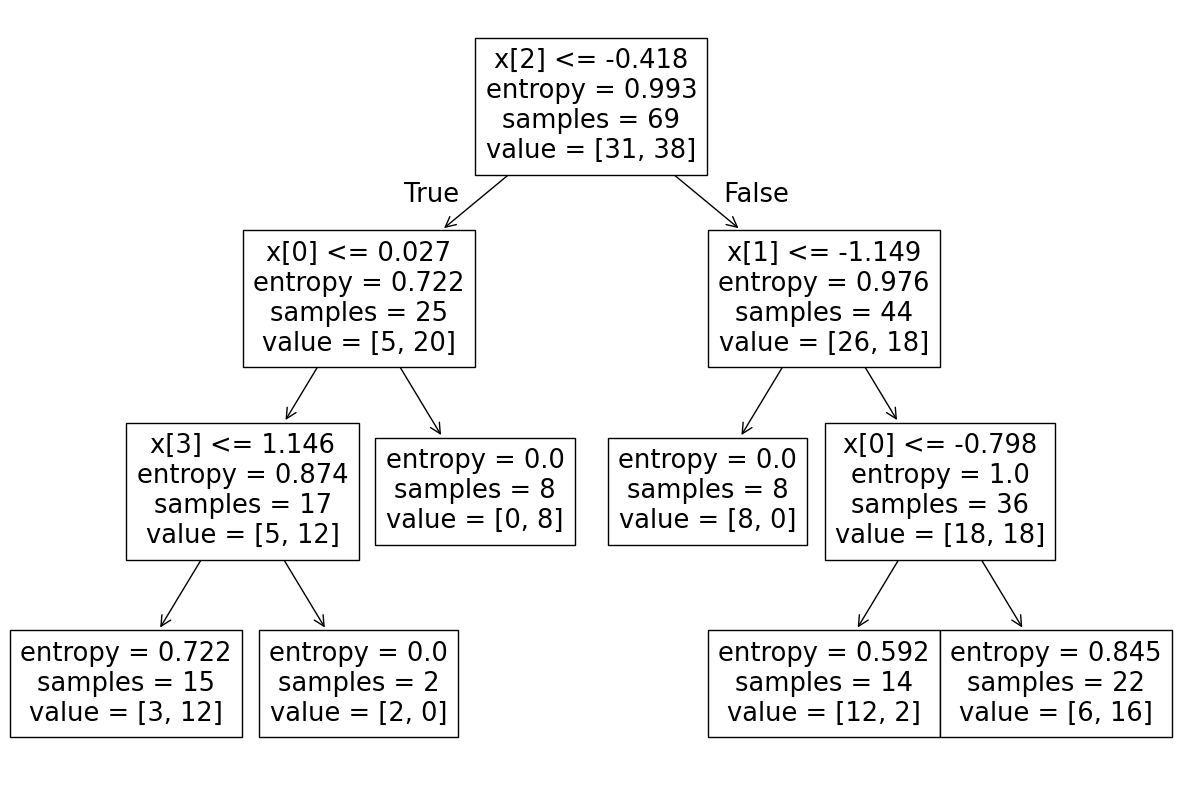

In [116]:
model = train_decision_tree(X_train_do_a_reduction_data_pca, y_train, criterion='entropy', max_depth=3)
ydriction, metrics  = predict(model, X_test_do_a_reduction_data_pca, y_test)

view_metrics("Teste - Decision Tree a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - Decision Tree a seguir ao Data) ---
Sensitivity(%) = 63.64
Specificity(%) = 61.54
Precision(%) = 58.33
F1Score(%) = 60.87
Accuracy(%) = 62.50
Confusion Matrix:
 [[7 4]
 [5 8]]


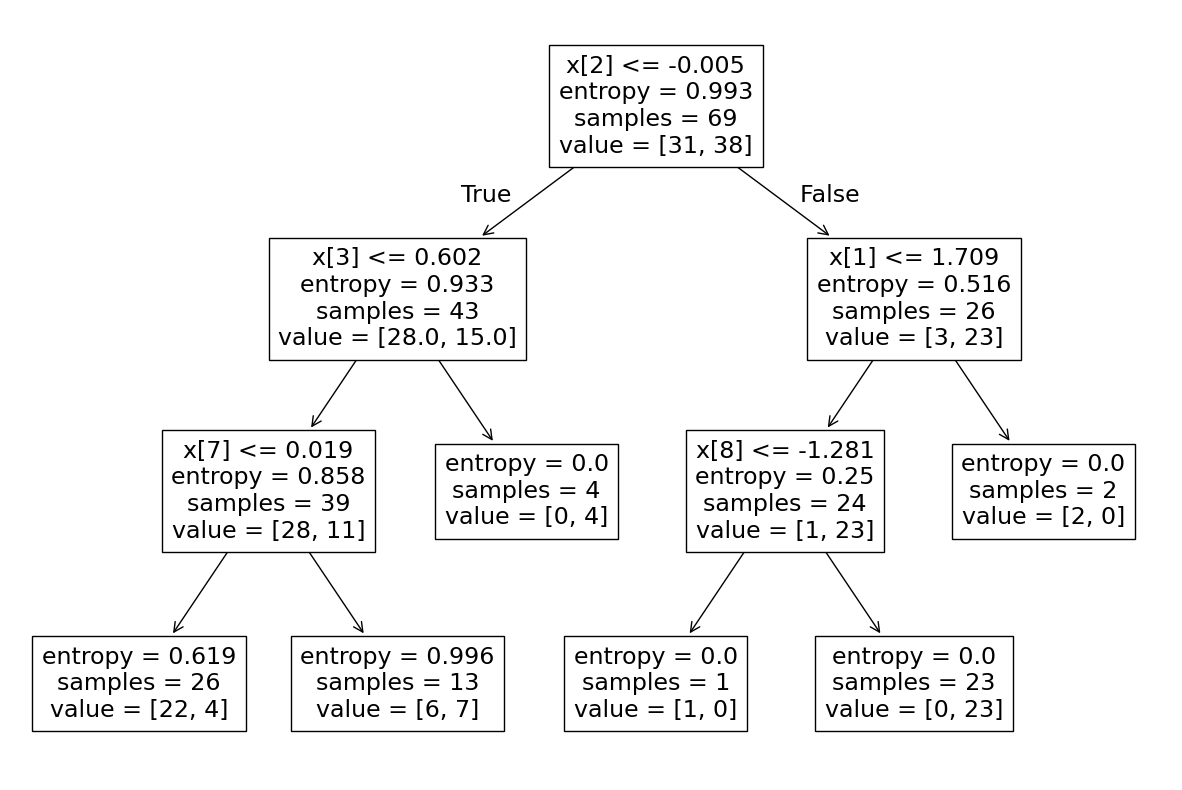

In [117]:
model = train_decision_tree(X_train_do_a_data_std, y_train, criterion='entropy', max_depth=3)
ydriction, metrics  = predict(model, X_test_do_a_data_std, y_test)

view_metrics("Teste - Decision Tree a seguir ao Data", metrics)

In [118]:
def trainAdaboost(Xtr, ytr, nMod):
    """Train AdaBoost ensemble classifier using Decision Trees."""
    y_convert = np.where(ytr == 1, -1, 1)
    models = np.arange(nMod, dtype=DecisionTreeClassifier)
    N = Xtr.shape[0]
    w = np.ones((N)) * (1/N)
    
    for i in range(nMod):
        mdl = DecisionTreeClassifier(criterion='gini', max_depth=1)
        mdl.fit(Xtr, y_convert, sample_weight=w)
        pred = mdl.predict(Xtr)
        models[i] = mdl
        err = sum(w * np.heaviside(-y_convert * pred, 1))
        alpha = 0.5 * np.log((1 - err) / err)
        models[i].alpha = alpha
        v = np.zeros((N))
        for j in range(N):
            v[j] = w[j] * np.exp(-alpha * y_convert[j] * pred[j])
        Sm = np.sum(v)
        w = v / Sm
    return models

def testAdaboost(models, Xte):
    """Classify using AdaBoost ensemble."""
    nMod = models.shape[0]
    nsamp = Xte.shape[0]
    predTot = np.zeros((nMod, nsamp))
    for m in range(nMod):
        label = models[m].predict(Xte)
        predTot[m, :] = models[m].alpha * label
    y = np.sign(np.sum(predTot, 0))
    y_convert = np.where(y == -1, 1, 2)
    return y_convert

model = trainAdaboost(X_train_std, y_train, 5)
ydriction = testAdaboost(model, X_test_std)

y = y_test.to_numpy()
metrics = calculate_metrics(y, ydriction)

view_metrics("Teste - AdaBoost a seguir ao Kruskal", metrics)


--- Métricas de Performance (Teste - AdaBoost a seguir ao Kruskal) ---
Sensitivity(%) = 54.55
Specificity(%) = 84.62
Precision(%) = 75.00
F1Score(%) = 63.16
Accuracy(%) = 70.83
Confusion Matrix:
 [[ 6  5]
 [ 2 11]]


In [119]:
model = trainAdaboost(X_train_lda_transformed, y_train, 5)
ydriction = testAdaboost(model, X_test_lda_transformed)

y = y_test.to_numpy()
metrics = calculate_metrics(y, ydriction)


view_metrics("Teste - AdaBoost a seguir ao LDA", metrics)


--- Métricas de Performance (Teste - AdaBoost a seguir ao LDA) ---
Sensitivity(%) = 45.45
Specificity(%) = 46.15
Precision(%) = 41.67
F1Score(%) = 43.48
Accuracy(%) = 45.83
Confusion Matrix:
 [[5 6]
 [7 6]]


In [120]:
model = trainAdaboost(X_train_do_reduction_pca, y_train, 5)
ydriction = testAdaboost(model, X_test_do_reduction_pca)

y = y_test.to_numpy()
metrics = calculate_metrics(y, ydriction)

view_metrics("Teste - AdaBoost a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - AdaBoost a seguir ao PCA) ---
Sensitivity(%) = 54.55
Specificity(%) = 53.85
Precision(%) = 50.00
F1Score(%) = 52.17
Accuracy(%) = 54.17
Confusion Matrix:
 [[6 5]
 [6 7]]


In [121]:
model = trainAdaboost(X_train_lda_a_data_transformed, y_train, 5)
ydriction = testAdaboost(model, X_test_lda_a_data_tranformed)

y = y_test.to_numpy()
metrics = calculate_metrics(y, ydriction)

view_metrics("Teste - AdaBoost a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - AdaBoost a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 53.85
Precision(%) = 60.00
F1Score(%) = 69.23
Accuracy(%) = 66.67
Confusion Matrix:
 [[9 2]
 [6 7]]


In [122]:
model = trainAdaboost(X_train_do_a_reduction_data_pca, y_train, 5)
ydriction = testAdaboost(model, X_test_do_a_reduction_data_pca)

y = y_test.to_numpy()
metrics = calculate_metrics(y, ydriction)

view_metrics("Teste - AdaBoost a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - AdaBoost a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 72.73
Specificity(%) = 61.54
Precision(%) = 61.54
F1Score(%) = 66.67
Accuracy(%) = 66.67
Confusion Matrix:
 [[8 3]
 [5 8]]


In [123]:
model = trainAdaboost(X_train_do_a_data_std, y_train, 5)
ydriction = testAdaboost(model, X_test_do_a_data_std)

y = y_test.to_numpy()
metrics = calculate_metrics(y, ydriction)

view_metrics("Teste - AdaBoost a seguir ao Data", metrics)


--- Métricas de Performance (Teste - AdaBoost a seguir ao Data) ---
Sensitivity(%) = 54.55
Specificity(%) = 100.00
Precision(%) = 100.00
F1Score(%) = 70.59
Accuracy(%) = 79.17
Confusion Matrix:
 [[ 6  5]
 [ 0 13]]


In [124]:
from sklearn.ensemble import RandomForestClassifier

def train_and_evaluate_a_rf(Xtr, ytr, Xte, yte, n_estimators=100):
    """Train Random Forest and evaluate performance."""
    modelo = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    modelo.fit(Xtr, ytr)
    ydriction = modelo.predict(Xte)
    
    y = yte.to_numpy() if hasattr(yte, 'to_numpy') else np.asarray(yte)
    metrics = calculate_metrics(y, ydriction)
    return ydriction, metrics,


ydriction, metrics= train_and_evaluate_a_rf(X_train_std, y_train, X_test_std, y_test)
view_metrics("Teste - Random Forest a seguir ao Kruskal", metrics)




--- Métricas de Performance (Teste - Random Forest a seguir ao Kruskal) ---
Sensitivity(%) = 81.82
Specificity(%) = 46.15
Precision(%) = 56.25
F1Score(%) = 66.67
Accuracy(%) = 62.50
Confusion Matrix:
 [[9 2]
 [7 6]]


In [125]:
ydriction, metrics= train_and_evaluate_a_rf(X_train_lda_transformed, y_train, X_test_lda_transformed, y_test)
view_metrics("Teste - Random Forest a seguir ao LDA", metrics)


--- Métricas de Performance (Teste - Random Forest a seguir ao LDA) ---
Sensitivity(%) = 45.45
Specificity(%) = 30.77
Precision(%) = 35.71
F1Score(%) = 40.00
Accuracy(%) = 37.50
Confusion Matrix:
 [[5 6]
 [9 4]]


In [126]:
ydriction, metrics= train_and_evaluate_a_rf(X_train_do_reduction_pca, y_train, X_test_do_reduction_pca, y_test)
view_metrics("Teste - Random Forest a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - Random Forest a seguir ao PCA) ---
Sensitivity(%) = 54.55
Specificity(%) = 61.54
Precision(%) = 54.55
F1Score(%) = 54.55
Accuracy(%) = 58.33
Confusion Matrix:
 [[6 5]
 [5 8]]


In [127]:
ydriction, metrics= train_and_evaluate_a_rf(X_train_lda_a_data_transformed, y_train, X_test_lda_a_data_tranformed, y_test)
view_metrics("Teste - Random Forest a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - Random Forest a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 63.64
Specificity(%) = 46.15
Precision(%) = 50.00
F1Score(%) = 56.00
Accuracy(%) = 54.17
Confusion Matrix:
 [[7 4]
 [7 6]]


In [128]:
ydriction, metrics= train_and_evaluate_a_rf(X_train_do_a_reduction_data_pca, y_train, X_test_do_a_reduction_data_pca, y_test)
view_metrics("Teste - Random Forest a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - Random Forest a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 63.64
Specificity(%) = 69.23
Precision(%) = 63.64
F1Score(%) = 63.64
Accuracy(%) = 66.67
Confusion Matrix:
 [[7 4]
 [4 9]]


In [129]:
ydriction, metrics= train_and_evaluate_a_rf(X_train_do_a_data_std, y_train, X_test_do_a_data_std, y_test)
view_metrics("Teste - Random Forest a seguir ao Data", metrics)


--- Métricas de Performance (Teste - Random Forest a seguir ao Data) ---
Sensitivity(%) = 72.73
Specificity(%) = 69.23
Precision(%) = 66.67
F1Score(%) = 69.57
Accuracy(%) = 70.83
Confusion Matrix:
 [[8 3]
 [4 9]]


In [130]:
from sklearn import svm

def train_and_evaluate_svm(Xtr, ytr, Xte, yte, kernel='linear'):
    """Train SVM and evaluate performance."""
    model = svm.SVC(kernel=kernel)
    model.fit(Xtr, ytr)
    ydriction = model.predict(Xte)
    
    y = yte.to_numpy() if hasattr(yte, 'to_numpy') else np.asarray(yte)
    metrics = calculate_metrics(y, ydriction)
    return ydriction, metrics


ydriction, metrics= train_and_evaluate_svm(X_train_std, y_train, X_test_std, y_test, kernel='linear')
view_metrics("Teste - SVM Linear a seguir ao Kruskal", metrics)



--- Métricas de Performance (Teste - SVM Linear a seguir ao Kruskal) ---
Sensitivity(%) = 63.64
Specificity(%) = 46.15
Precision(%) = 50.00
F1Score(%) = 56.00
Accuracy(%) = 54.17
Confusion Matrix:
 [[7 4]
 [7 6]]


In [131]:
ydriction, metrics= train_and_evaluate_svm(X_train_lda_transformed, y_train, X_test_lda_transformed, y_test, kernel='linear')
view_metrics("Teste - SVM Linear a seguir ao LDA", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao LDA) ---
Sensitivity(%) = 72.73
Specificity(%) = 46.15
Precision(%) = 53.33
F1Score(%) = 61.54
Accuracy(%) = 58.33
Confusion Matrix:
 [[8 3]
 [7 6]]


In [132]:
ydriction, metrics= train_and_evaluate_svm(X_train_do_reduction_pca, y_train, X_test_do_reduction_pca, y_test, kernel='linear')
view_metrics("Teste - SVM Linear a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao PCA) ---
Sensitivity(%) = 63.64
Specificity(%) = 46.15
Precision(%) = 50.00
F1Score(%) = 56.00
Accuracy(%) = 54.17
Confusion Matrix:
 [[7 4]
 [7 6]]


In [133]:
ydriction, metrics= train_and_evaluate_svm(X_train_lda_a_data_transformed, y_train, X_test_lda_a_data_tranformed, y_test, kernel='linear')
view_metrics("Teste - SVM Linear a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 61.54
Precision(%) = 64.29
F1Score(%) = 72.00
Accuracy(%) = 70.83
Confusion Matrix:
 [[9 2]
 [5 8]]


In [134]:
ydriction, metrics= train_and_evaluate_svm(X_train_do_a_reduction_data_pca, y_train, X_test_do_a_reduction_data_pca, y_test, kernel='linear')
view_metrics("Teste - SVM Linear a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 61.54
Precision(%) = 64.29
F1Score(%) = 72.00
Accuracy(%) = 70.83
Confusion Matrix:
 [[9 2]
 [5 8]]


In [135]:
ydriction, metrics= train_and_evaluate_svm(X_train_do_a_data_std, y_train, X_test_do_a_data_std, y_test, kernel='linear')
view_metrics("Teste - SVM Linear a seguir ao Data", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 61.54
Precision(%) = 64.29
F1Score(%) = 72.00
Accuracy(%) = 70.83
Confusion Matrix:
 [[9 2]
 [5 8]]


In [136]:
ydriction, metrics= train_and_evaluate_svm(X_train_std, y_train, X_test_std, y_test, kernel='rbf')
view_metrics("Teste - SVM Linear a seguir ao Kruskal", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao Kruskal) ---
Sensitivity(%) = 63.64
Specificity(%) = 53.85
Precision(%) = 53.85
F1Score(%) = 58.33
Accuracy(%) = 58.33
Confusion Matrix:
 [[7 4]
 [6 7]]


In [137]:
ydriction, metrics= train_and_evaluate_svm(X_train_lda_transformed, y_train, X_test_lda_transformed, y_test, kernel='rbf')
view_metrics("Teste - SVM Linear a seguir ao LDA", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao LDA) ---
Sensitivity(%) = 72.73
Specificity(%) = 46.15
Precision(%) = 53.33
F1Score(%) = 61.54
Accuracy(%) = 58.33
Confusion Matrix:
 [[8 3]
 [7 6]]


In [138]:
ydriction, metrics= train_and_evaluate_svm(X_train_do_reduction_pca, y_train, X_test_do_reduction_pca, y_test, kernel='rbf')
view_metrics("Teste - SVM Linear a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao PCA) ---
Sensitivity(%) = 63.64
Specificity(%) = 61.54
Precision(%) = 58.33
F1Score(%) = 60.87
Accuracy(%) = 62.50
Confusion Matrix:
 [[7 4]
 [5 8]]


In [139]:
ydriction, metrics= train_and_evaluate_svm(X_train_lda_a_data_transformed, y_train, X_test_lda_a_data_tranformed, y_test, kernel='rbf')
view_metrics("Teste - SVM Linear a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 61.54
Precision(%) = 64.29
F1Score(%) = 72.00
Accuracy(%) = 70.83
Confusion Matrix:
 [[9 2]
 [5 8]]


In [140]:
ydriction, metrics= train_and_evaluate_svm(X_train_do_a_reduction_data_pca, y_train, X_test_do_a_reduction_data_pca, y_test, kernel='rbf')
view_metrics("Teste - SVM Linear a seguir ao PCA com dados do Data", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 63.64
Specificity(%) = 76.92
Precision(%) = 70.00
F1Score(%) = 66.67
Accuracy(%) = 70.83
Confusion Matrix:
 [[ 7  4]
 [ 3 10]]


In [141]:
ydriction, metrics= train_and_evaluate_svm(X_train_do_a_data_std, y_train, X_test_do_a_data_std, y_test, kernel='rbf')
view_metrics("Teste - SVM Linear a seguir ao Data", metrics)


--- Métricas de Performance (Teste - SVM Linear a seguir ao Data) ---
Sensitivity(%) = 72.73
Specificity(%) = 53.85
Precision(%) = 57.14
F1Score(%) = 64.00
Accuracy(%) = 62.50
Confusion Matrix:
 [[8 3]
 [6 7]]


In [142]:
def find_best_k(X_train, y_train):
    """Find the best k value for k-NN using cross-validation.
    
    Args:
        X_train: Training features
        y_train: Training labels  
        ks: Array of k values to test (default: odd numbers 1-29)
        runs: Number of random train/test splits (default: 30)
        
    Returns:
        best_k: The k value with lowest average error
        avg_error: Average error for each k
        std_error: Standard deviation of error for each k
    """
    from sklearn.neighbors import KNeighborsClassifier
    
   
    ks = np.arange(1, 30, 2)
    
    runs_arr = np.arange(0,30)
    errMat = np.zeros((runs_arr.shape[0], ks.shape[0]))
    
    for r in runs_arr:
        X_trainr, X_testr, y_trainr, y_testr = train_test_split(
            X_train, y_train, train_size=0.5, test_size=0.5
        )
        
        muTr = np.mean(X_trainr, axis=0)
        stdTr = np.std(X_trainr, axis=0)
        stdTr[stdTr == 0] = 1
        
        X_trainr_std = (X_trainr - muTr) / stdTr
        X_testr_std = (X_testr - muTr) / stdTr
        ki=0
        for ki,k in enumerate(ks):
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_trainr_std, y_trainr)
            yp = knn.predict(X_testr_std)
            
            Hits = np.sum(yp == y_testr)
            Acc = Hits / len(y_testr)
            errMat[r, ki] = (1 - Acc) * 100
            
    avg_error = np.mean(errMat, axis=0)
    std_error = np.std(errMat, axis=0)
    best_k = ks[np.argmin(avg_error)]
    
    return best_k, avg_error, std_error


def train_knn(X_train, y_train, n_neighbors=3):
    """Train a k-NN classifier."""
    from sklearn.neighbors import KNeighborsClassifier
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    return knn


def evaluate_knn(model, X_test, y_test):
    """Evaluate a k-NN classifier."""
    from sklearn.metrics import confusion_matrix
    
    y_pred = model.predict(X_test)
    y = y_test if isinstance(y_test, np.ndarray) else y_test.to_numpy()
    
    metrics = calculate_metrics(y, y_pred)
        
    return y_pred, metrics


def run_knn_experiment(X_train, y_train, X_test, y_test, best_k ,ks=None, runs=50):
    """Run a complete k-NN experiment: find best k, train, and evaluate."""
    
    model = train_knn(X_train, y_train, n_neighbors=best_k)
    y_pred, metrics= evaluate_knn(model, X_test, y_test)
    
    return y_pred, metrics

In [152]:
best_k_std,avgError_std, stdError_std = find_best_k(
    X_train_std, y_train)

print(f"Melhor k a usar Kruskal: {best_k_std}")

best_k_lda, avgError_lda, stdError_lda = find_best_k(
    X_train_lda_transformed, y_train
)
print(f"Melhor k a usar LDA: {best_k_lda}")
# Encontrar melhor k para PCA (executar uma vez)
best_k_a_usar_pca, avgError_pca, stdError_pca = find_best_k(
    X_train_do_reduction_pca, y_train
)
print(f"Melhor k a usar PCA: {best_k_a_usar_pca}")
best_k_lda_com_dados_do_Data, avgError_com_dados_Data_lda, stdError_com_dados_Data_lda = find_best_k(
    X_train_lda_a_data_transformed, y_train)
print(f"Melhor k a usar LDA com dados do Data: {best_k_lda_com_dados_do_Data}")
best_k_a_usar_pca_com_dados_do_Data, avgError_pca_com_dados_do_Data, stdError_pca_com_dados_do_Data = find_best_k(
    X_train_do_a_reduction_data_pca, y_train)
print(f"Melhor k a usar PCA com dados do Data: {best_k_a_usar_pca_com_dados_do_Data}")
best_k_a_usar_dados_do_Data, avgError_dados_do_Data, stdError_dados_do_Data = find_best_k(
    X_train_do_a_data_std, y_train)
print(f"Melhor k a usar dados do Data: {best_k_a_usar_dados_do_Data}")

best_k_a_usar_pca = 9 #melhor
best_k_lda = 15 #melhor
best_k_std = 9 #melhor
best_k_lda_com_dados_do_Data = 21 #melhor
best_k_a_usar_pca_com_dados_do_Data = 1 #melhor
best_k_a_usar_dados_do_Data = 9 #melhor

Melhor k a usar Kruskal: 9
Melhor k a usar LDA: 15
Melhor k a usar PCA: 5
Melhor k a usar LDA com dados do Data: 11
Melhor k a usar PCA com dados do Data: 1
Melhor k a usar dados do Data: 7


In [155]:
y, metrics= run_knn_experiment(
    X_train_std, y_train, 
    X_test_std, y_test,
    best_k_std 
)
view_metrics("Teste - k-NN a seguir ao Kruskal", metrics)



--- Métricas de Performance (Teste - k-NN a seguir ao Kruskal) ---
Sensitivity(%) = 72.73
Specificity(%) = 53.85
Precision(%) = 57.14
F1Score(%) = 64.00
Accuracy(%) = 62.50
Confusion Matrix:
 [[8 3]
 [6 7]]


In [156]:
y, metrics= run_knn_experiment(
    X_train_lda_transformed, y_train, 
    X_test_lda_transformed, y_test,
    best_k_lda 
)
view_metrics("Teste - k-NN a seguir ao LDA", metrics)



--- Métricas de Performance (Teste - k-NN a seguir ao LDA) ---
Sensitivity(%) = 72.73
Specificity(%) = 46.15
Precision(%) = 53.33
F1Score(%) = 61.54
Accuracy(%) = 58.33
Confusion Matrix:
 [[8 3]
 [7 6]]


In [157]:
y, metrics= run_knn_experiment(
    X_train_do_reduction_pca, y_train, 
    X_test_do_reduction_pca, y_test,
    best_k_a_usar_pca 
)
view_metrics("Teste - k-NN a seguir ao PCA", metrics)


--- Métricas de Performance (Teste - k-NN a seguir ao PCA) ---
Sensitivity(%) = 63.64
Specificity(%) = 69.23
Precision(%) = 63.64
F1Score(%) = 63.64
Accuracy(%) = 66.67
Confusion Matrix:
 [[7 4]
 [4 9]]


In [158]:
y, metrics= run_knn_experiment(
    X_train_lda_a_data_transformed, y_train, 
    X_test_lda_a_data_tranformed, y_test,
    best_k_lda_com_dados_do_Data 
)
view_metrics("Teste - k-NN a seguir ao LDA com dados do Data", metrics)


--- Métricas de Performance (Teste - k-NN a seguir ao LDA com dados do Data) ---
Sensitivity(%) = 81.82
Specificity(%) = 53.85
Precision(%) = 60.00
F1Score(%) = 69.23
Accuracy(%) = 66.67
Confusion Matrix:
 [[9 2]
 [6 7]]


In [159]:
y, metrics= run_knn_experiment(
    X_train_do_a_reduction_data_pca, y_train, 
    X_test_do_a_reduction_data_pca, y_test,
    best_k_a_usar_pca_com_dados_do_Data 
)
view_metrics("Teste - k-NN a seguir ao PCA com dados do Data", metrics)



--- Métricas de Performance (Teste - k-NN a seguir ao PCA com dados do Data) ---
Sensitivity(%) = 54.55
Specificity(%) = 76.92
Precision(%) = 66.67
F1Score(%) = 60.00
Accuracy(%) = 66.67
Confusion Matrix:
 [[ 6  5]
 [ 3 10]]


In [160]:
y, metrics= run_knn_experiment(
    X_train_do_a_data_std, y_train, 
    X_test_do_a_data_std, y_test,
    best_k_a_usar_dados_do_Data 
)
view_metrics("Teste - k-NN a seguir ao Data", metrics)



--- Métricas de Performance (Teste - k-NN a seguir ao Data) ---
Sensitivity(%) = 72.73
Specificity(%) = 76.92
Precision(%) = 72.73
F1Score(%) = 72.73
Accuracy(%) = 75.00
Confusion Matrix:
 [[ 8  3]
 [ 3 10]]
